   # <center> Notebook to synthesise data 

### This notebook is to help synthetise data using a very simple model (ST- : single temperature)

### For more complex model, see: 
https://xpsi-group.github.io/xpsi/model_construction.html

### ------------------------------------------------------------------------------------------------------------------------------------------------------------


## <center> Importing modules

In [1]:
from __future__ import print_function, division

%matplotlib inline

import os
import numpy as np
import math


from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MultipleLocator, AutoLocator, AutoMinorLocator
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches


import xpsi
from xpsi import Parameter
from scipy.interpolate import Akima1DInterpolator
from xpsi.global_imports import _c, _G, _dpr, gravradius, _csq, _km, _2pi

/=============================================\
| X-PSI: X-ray Pulse Simulation and Inference |
|---------------------------------------------|
|                Version: 1.2.1               |
|---------------------------------------------|
|      https://xpsi-group.github.io/xpsi      |
\=============================================/

Imported GetDist version: 1.4
Imported nestcheck version: 0.2.1


## <center> Creating and instantiating a fake instrument object

We create a fake telescope response.

This fake instrument has:
- Energy range of 0.1-15 keV
- A perfect normalized RMF 
- An effective area of 1800 cm2 for each photon energy bin
- Channel edges 

In [2]:



channel_number=np.arange(0,1501)    # The channel nnumber
energy_low=np.arange(0,15.01, 0.01) # Lower bounds of each channel
energy_high=energy_low+0.01         # Upper bounds of each channel
channel_edges=np.array([list(channel_number),list(energy_low),list(energy_high)]).T

# ARF
arf_energy_low=[0.1]
arf_energy_high=[0.105]
arf_val=[1800]

counter=1
while arf_energy_low[-1]<=14.995:
    arf_energy_low.append(arf_energy_low[-1]+0.005)
    arf_energy_high.append(arf_energy_high[-1]+0.005)
    arf_val.append(1800)
    counter +=1


ARF=np.array([list(arf_energy_low),
              list(arf_energy_high),
              list(arf_val)]).T

# RMF
RMF=np.diag(np.full(counter,1))        

Text(0, 0.5, 'Efective area (cm^2)')

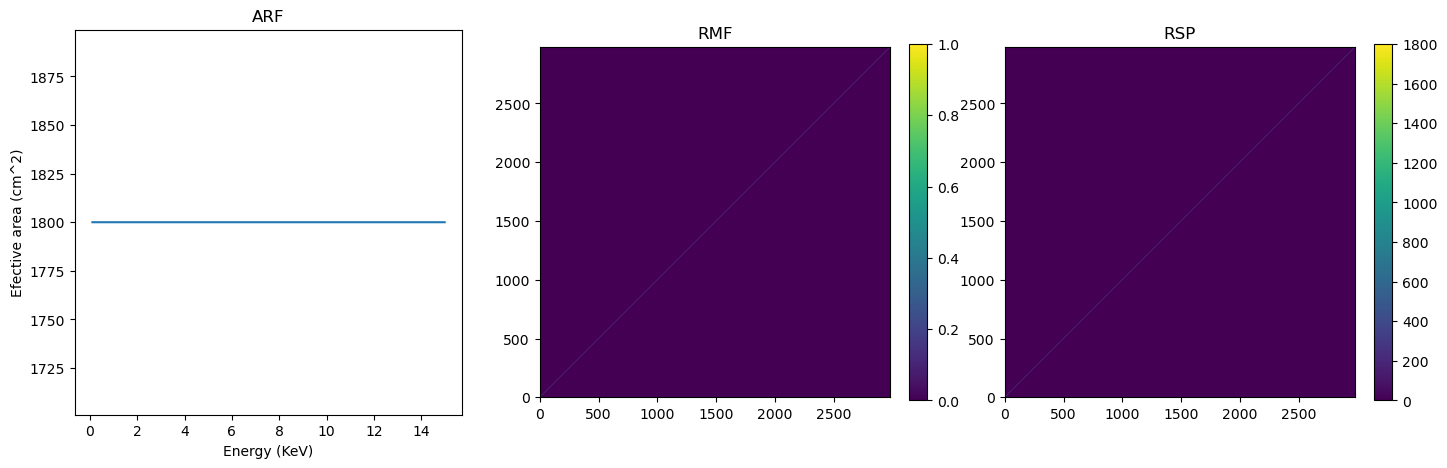

In [3]:
# Quick plot to show what we have created

fig,ax=plt.subplots(1,3,figsize=(17,5))
ax[0].plot(ARF[:,0],ARF[:,2])
rmf=ax[1].imshow(RMF,origin="lower")#,aspect="auto")
rsp=ax[2].imshow(RMF*ARF[:,2],origin="lower")#,extent = [0, 1500, 0, ],aspect=1)

plt.colorbar(rmf,ax=ax[1], fraction=0.046, pad=0.05)
plt.colorbar(rsp,ax=ax[2],fraction=0.046, pad=0.05, shrink=1)

ax[0].set_title('ARF')
ax[1].set_title('RMF')
ax[2].set_title('RSP')

ax[0].set_xlabel("Energy (KeV)")
ax[0].set_ylabel("Efective area (cm^2)")

In [4]:
# Instrument Class

class CustomInstrument(xpsi.Instrument):
    
    """ Fake telescope response. """
    
    

    def __call__(self, signal, *args):
        """ Overwrite base just to show it is possible.

        We loaded only a submatrix of the total instrument response
        matrix into memory, so here we can simplify the method in the
        base class.

        """
        matrix = self.construct_matrix()

        self._folded_signal = np.dot(matrix, signal)

        return self._folded_signal

    @classmethod
    def from_response_files(cls, ARF, RMF, max_input, min_input=0,channel=[1,1500],
                            channel_edges=None):
        """ Constructor which converts response files into :class:`numpy.ndarray`s.
        :param str ARF: Path to ARF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str RMF: Path to RMF which is compatible with
                                :func:`numpy.loadtxt`.
        :param str channel_edges: Optional path to edges which is compatible with
                                  :func:`numpy.loadtxt`.
        """

        if min_input != 0:
            min_input = int(min_input)

        max_input = int(max_input)

        matrix = np.ascontiguousarray(RMF[min_input:max_input,channel[0]:channel[1]].T, dtype=np.double)

        edges = np.zeros(ARF[min_input:max_input,2].shape[0]+1, dtype=np.double)
        
        

        edges[0] = ARF[min_input,0]; edges[1:] = ARF[min_input:max_input,1]

        for i in range(matrix.shape[0]):
            matrix[i,:] *= ARF[min_input:max_input,2]
    

        channels = np.arange(channel[0],channel[1])
    

        return cls(matrix, edges, channels, channel_edges[channel[0]:channel[1]+1,1])


###  Because this RSP in ideal and perfectly diagonal:
###  then max_input, min_input =channel[1], channel[0]


In [5]:
Instrument = CustomInstrument.from_response_files(ARF =ARF,
                                             RMF = RMF,
                                             max_input = 301,
                                             min_input = 10,
                                             channel=[10,301],
                                             channel_edges =channel_edges)

Setting channels for loaded instrument response (sub)matrix...
Channels set.
No parameters supplied... empty subspace created.


# Signal

In [6]:
# Nothing very special here

import six as _six

from xpsi.likelihoods.default_background_marginalisation import eval_marginal_likelihood
from xpsi.likelihoods.default_background_marginalisation import precomputation

class CustomSignal(xpsi.Signal):
    """ A custom calculation of the logarithm of the NICER likelihood.

    We extend the :class:`xpsi.Signal.Signal` class to make it callable.

    We overwrite the body of the __call__ method. The docstring for the
    abstract method is copied.

    """

    def __init__(self, workspace_intervals = 1000, epsabs = 0, epsrel = 1.0e-8,
                 epsilon = 1.0e-3, sigmas = 10.0, support = None, *args, **kwargs):
        """ Perform precomputation. """

        super(CustomSignal, self).__init__(*args, **kwargs)

        try:
            self._precomp = precomputation(self._data.counts.astype(np.int32))
        except AttributeError:
            print('No data... can synthesise data but cannot evaluate a '
                  'likelihood function.')
        else:
            self._workspace_intervals = workspace_intervals
            self._epsabs = epsabs
            self._epsrel = epsrel
            self._epsilon = epsilon
            self._sigmas = sigmas

            if support is not None:
                self._support = support
            else:
                self._support = -1.0 * np.ones((self._data.counts.shape[0],2))
                self._support[:,0] = 0.0

    @property
    def support(self):
        return self._support

    @support.setter
    def support(self, obj):
        self._support = obj

    def __call__(self, *args, **kwargs):
        self.loglikelihood, self.expected_counts, self.background_signal,self.background_given_support = \
                eval_marginal_likelihood(self._data.exposure_time,
                                          self._data.phases,
                                          self._data.counts,
                                          self._signals,
                                          self._phases,
                                          self._shifts,
                                          self._precomp,
                                          self._support,
                                          self._workspace_intervals,
                                          self._epsabs,
                                          self._epsrel,
                                          self._epsilon,
                                          self._sigmas,
                                          kwargs.get('llzero'))


# Space-time

In [7]:
bounds = dict(distance = (0.1, 10.0),                       # (Earth) distance
                mass = (1.0, 3.0),                          # mass
                radius = (3.0 * gravradius(1.0), 16.0),     # equatorial radius
                cos_inclination = (0.0, 1.0))               # (Earth) inclination to rotation axis

spacetime = xpsi.Spacetime(bounds=bounds, values=dict(frequency=314.0))# Fixing the spin


Creating parameter:
    > Named "frequency" with fixed value 3.140e+02.
    > Spin frequency [Hz].
Creating parameter:
    > Named "mass" with bounds [1.000e+00, 3.000e+00].
    > Gravitational mass [solar masses].
Creating parameter:
    > Named "radius" with bounds [4.430e+00, 1.600e+01].
    > Coordinate equatorial radius [km].
Creating parameter:
    > Named "distance" with bounds [1.000e-01, 1.000e+01].
    > Earth distance [kpc].
Creating parameter:
    > Named "cos_inclination" with bounds [0.000e+00, 1.000e+00].
    > Cosine of Earth inclination to rotation axis.


# Hot-spot

### We will use a single hot-spot. For complex models, see:
https://xpsi-group.github.io/xpsi



In [8]:
# Using default hard-coded bounds

bounds = dict(super_colatitude = (None, None),
              super_radius = (None, None),
              phase_shift = (-0.25, 0.75),
              super_temperature = (None, None))

# a simple circular, simply-connected spot
hot_spot = xpsi.HotRegion(bounds=bounds,
                            values={}, # no initial values and no derived/fixed
                            symmetry=True,
                            omit=False,
                            cede=False,
                            concentric=False,
                            sqrt_num_cells=32,
                            min_sqrt_num_cells=10,
                            max_sqrt_num_cells=64,
                            num_leaves=100,
                            num_rays=200,
                            is_antiphased=True, 
                            prefix='hot') # unique prefix needed because >1 instance


Creating parameter:
    > Named "super_colatitude" with bounds [0.000e+00, 3.142e+00].
    > The colatitude of the centre of the superseding region [radians].
Creating parameter:
    > Named "super_radius" with bounds [0.000e+00, 1.571e+00].
    > The angular radius of the (circular) superseding region [radians].
Creating parameter:
    > Named "phase_shift" with bounds [-2.500e-01, 7.500e-01].
    > The phase of the hot region, a periodic parameter [cycles].
Creating parameter:
    > Named "super_temperature" with bounds [3.000e+00, 7.600e+00].
    > log10(superseding region effective temperature [K]).


# Phostosphere

### We will use  here the defaulf black-body emission model. No emission from the rest of the star, all the emission is from the hot-spot

In [9]:
class CustomPhotosphere(xpsi.Photosphere):
    """ Implement method for imaging."""

    @property
    def global_variables(self):

        return np.array([self['hot__super_colatitude'],
                          self['hot__phase_shift'] * _2pi,
                          self['hot__super_radius'],
                          self['hot__super_temperature']])

photosphere = CustomPhotosphere(hot = hot_spot, elsewhere = None,
                                values=dict(mode_frequency = spacetime['frequency']))



Creating parameter:
    > Named "mode_frequency" with fixed value 3.140e+02.
    > Coordinate frequency of the mode of radiative asymmetry in the
photosphere that is assumed to generate the pulsed signal [Hz].


# Star

In [10]:
# Star object
star = xpsi.Star(spacetime = spacetime, photospheres = photosphere)

# Prior



### Simple Prior class, nothing very fancy here

In [11]:


class CustomPrior(xpsi.Prior):
    """ A custom (joint) prior distribution.

    Source: Fictitious
    Model variant: ST-

    """

    __derived_names__ = ['compactness', 'phase_separation',]

    def __init__(self):
        """ Nothing to be done.

        A direct reference to the spacetime object could be put here
        for use in __call__:

        .. code-block::

            self.spacetime = ref

        Instead we get a reference to the spacetime object through the
        a reference to a likelihood object which encapsulates a
        reference to the spacetime object.

        """
        super(CustomPrior, self).__init__() # not strictly required if no hyperparameters

    def __call__(self, p = None):
        """ Evaluate distribution at ``p``.

        :param list p: Model parameter values.

        :returns: Logarithm of the distribution evaluated at ``p``.

        """
        temp = super(CustomPrior, self).__call__(p)
        if not np.isfinite(temp):
            return temp

        # based on contemporary EOS theory
        if not self.parameters['radius'] <= 16.0:
            return -np.inf

        ref = self.parameters.star.spacetime # shortcut

        # Compactness limit
        R_p = 1.0 + ref.epsilon * (-0.788 + 1.030 * ref.zeta)
        if R_p < 1.76 / ref.R_r_s:
            return -np.inf

        mu = math.sqrt(-1.0 / (3.0 * ref.epsilon * (-0.788 + 1.030 * ref.zeta)))

        # 2-surface cross-section have a single maximum in |z|
        # i.e., an elliptical surface; minor effect on support, if any,
        # for high spin frequenies
        if mu < 1.0:
            return -np.inf

        ref = self.parameters

        return 0.0

    def inverse_sample(self, hypercube=None):
        """ Draw sample uniformly from the distribution via inverse sampling. """

        to_cache = self.parameters.vector

        if hypercube is None:
            hypercube = np.random.rand(len(self))

        # the base method is useful, so to avoid writing that code again:
        _ = super(CustomPrior, self).inverse_sample(hypercube)

        ref = self.parameters # shortcut

        # restore proper cache
        for parameter, cache in zip(ref, to_cache):
            parameter.cached = cache

        # it is important that we return the desired vector because it is
        # automatically written to disk by MultiNest and only by MultiNest
        return self.parameters.vector

    def transform(self, p, **kwargs):
        """ A transformation for post-processing. """

        p = list(p) # copy

        # used ordered names and values
        ref = dict(zip(self.parameters.names, p))

        # compactness ratio M/R_eq
        p += [gravradius(ref['mass']) / ref['radius']]

        return p


In [12]:
# Prior object
prior = CustomPrior()

No parameters supplied... empty subspace created.


# Background

 ### Let's add some background photons for fun. Just a powerlaw component

In [13]:
class CustomBackground(xpsi.Background):
    """ The background injected to generate synthetic data. """

    def __init__(self, bounds=None, value=None):

        # first the parameters that are fundemental to this class
        doc = """
        Powerlaw spectral index.
        """
        index = xpsi.Parameter('powerlaw_index',
                                strict_bounds = (-4.0, -1.01),
                                bounds = bounds,
                                doc = doc,
                                symbol = r'$\Gamma$',
                                value = value)

        super(CustomBackground, self).__init__(index)

    def __call__(self, energy_edges, phases):
        """ Evaluate the incident background field. """

        G = self['powerlaw_index']

        temp = np.zeros((energy_edges.shape[0] - 1, phases.shape[0]))

        temp[:,0] = (energy_edges[1:]**(G + 1.0) - energy_edges[:-1]**(G + 1.0)) / (G + 1.0)

        for i in range(phases.shape[0]):
            temp[:,i] = temp[:,0]

        self._incident_background= temp

In [14]:


background = CustomBackground(bounds=(None, None))

Creating parameter:
    > Named "powerlaw_index" with bounds [-4.000e+00, -1.010e+00].
    > Powerlaw spectral index.


# Data

In [15]:
class SynthesiseData(xpsi.Data):
    """ Custom data container to enable synthesis. """

    def __init__(self, channels, phases, first, last):

        self.channels = channels
        self._phases = phases

        try:
            self._first = int(first)
            self._last = int(last)
        except TypeError:
            raise TypeError('The first and last channels must be integers.')
        if self._first >= self._last:
            raise ValueError('The first channel number must be lower than the '
                             'the last channel number.')

In [16]:
301-10-1

290

In [17]:
201-20-1

180

In [18]:
_data = SynthesiseData(np.arange(10,301), np.linspace(0.0, 1.0, 33), 0, 290 )

Setting channels for event data...
Channels set.


# Synthesing function

When creating synthetic data, we can fix the random seed for noise by providing it as an input parameter called 'gsl_seed'. If no input is provided, the seed is based on the clock time.

In [19]:

from xpsi.tools.synthesise import synthesise_exposure as _synthesise

def synthesise(self,
               exposure_time,
               expected_background_counts,
               name='synthetic',
               directory='./',
               **kwargs):
    
        """ Synthesise data set.

        """
        self._expected_counts, synthetic, bkg= _synthesise(exposure_time,
                                                             self._data.phases,
                                                             self._signals,
                                                             self._phases,
                                                             self._shifts,
                                                             expected_background_counts,
                                                             self._background.registered_background,
                                                             gsl_seed=42)
        
        try:
            if not os.path.isdir(directory):
                os.mkdir(directory)
        except OSError:
            print('Cannot create write directory.')
            raise

        np.savetxt(os.path.join(directory, name+'_realisation.dat'),
                   synthetic,
                   fmt = '%u')

        self._write(self.expected_counts,
                    filename = os.path.join(directory, name+'_expected_hreadable.dat'),
                    fmt = '%.8e')

        self._write(synthetic,
                    filename = os.path.join(directory, name+'_realisation_hreadable.dat'),
                    fmt = '%u')

def _write(self, counts, filename, fmt):
        """ Write to file in human readable format. """

        rows = len(self._data.phases) - 1
        rows *= len(self._data.channels)

        phases = self._data.phases[:-1]
        array = np.zeros((rows, 3))

        for i in range(counts.shape[0]):
            for j in range(counts.shape[1]):
                array[i*len(phases) + j,:] = self._data.channels[i], phases[j], counts[i,j]

            np.savetxt(filename, array, fmt=['%u', '%.6f'] + [fmt])


# Final settings

In [20]:
CustomSignal.synthesise = synthesise
CustomSignal._write = _write

signal = CustomSignal(data = _data,
                        instrument = Instrument,
                        background = background,
                        interstellar = None,
                        cache = True,
                        prefix='Instrument')



likelihood = xpsi.Likelihood(star = star, signals = signal,
                             num_energies=384,
                             threads=1,
                             externally_updated=False,
                             prior = prior)                             


for h in hot_spot.objects:
    h.set_phases(num_leaves = 100)


Creating parameter:
    > Named "phase_shift" with fixed value 0.000e+00.
    > The phase shift for the signal, a periodic parameter [cycles].
No data... can synthesise data but cannot evaluate a likelihood function.


In [21]:
likelihood

Free parameters
---------------
mass: Gravitational mass [solar masses].
radius: Coordinate equatorial radius [km].
distance: Earth distance [kpc].
cos_inclination: Cosine of Earth inclination to rotation axis.
hot__phase_shift: The phase of the hot region, a periodic parameter [cycles].
hot__super_colatitude: The colatitude of the centre of the superseding region [radians].
hot__super_radius: The angular radius of the (circular) superseding region [radians].
hot__super_temperature: log10(superseding region effective temperature [K]).
Instrument__powerlaw_index: Powerlaw spectral index.

In [22]:
print("Prosseccing ...")


p_T=[1.4,                         # Mass in solar Mass
     12,                          # Equatorial radius in km
     1.,                          # Distance in kpc
     math.cos(60*np.pi/180),      # Cosine of Earth inclination to rotation axis
     0.0,                         # Phase shift
     70*np.pi/180,                # Colatitude of the centre of the superseding region
     0.75,                        # Angular radius of the (circular) superseding region
     6.7,                         # Temperature in log 10
     -2                           # Background sprectral index : gamma (E^gamma) 
    ]

Instrument_kwargs = dict(exposure_time=1000.0,              
                         expected_background_counts=10000.0,
                         name='new_synthetic',
                         directory='./Data/')

likelihood.synthesise(p_T, force=True, Instrument=Instrument_kwargs) 

print("Done !")

Prosseccing ...
Done !


# Checkings

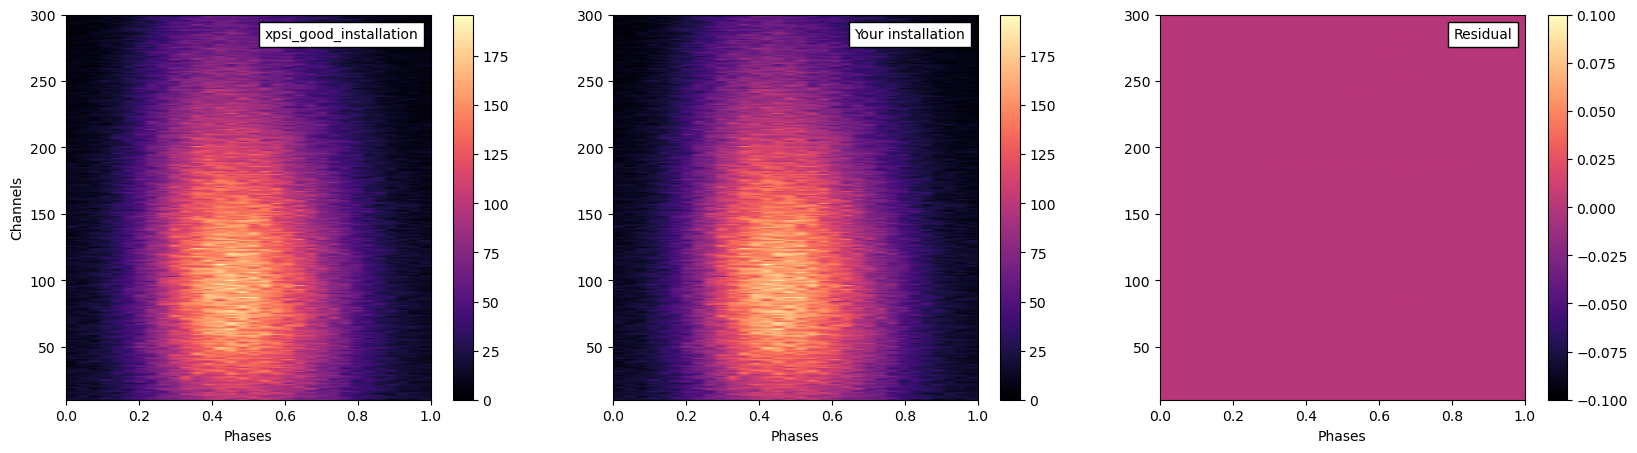

In [23]:
# Loading the data that you would get if the installation went well
good_xspi_data=np.loadtxt("./Data/xpsi_good_realisation.dat") 

# Loading the data that you got
your_data=np.loadtxt("./Data/new_synthetic_realisation.dat")

residual=(good_xspi_data-your_data)

fig,ax=plt.subplots(1,3,figsize=(20,5))

xpsi_d=ax[0].imshow(good_xspi_data,cmap=cm.magma,origin="lower", aspect="auto",extent=[0,1,10,300])
you_d=ax[1].imshow(your_data,cmap=cm.magma,origin="lower", aspect="auto",extent=[0,1,10,300])
res=ax[2].imshow(residual,cmap=cm.magma,origin="lower", aspect="auto",extent=[0,1,10,300])

anchored_text1 = AnchoredText("xpsi_good_installation",loc=1)
anchored_text2 = AnchoredText("Your installation",loc=1)
anchored_text3 = AnchoredText("Residual",loc=1)

ax[0].set_ylabel("Channels")
ax[0].set_xlabel("Phases")
ax[1].set_xlabel("Phases")
ax[2].set_xlabel("Phases")
ax[0].add_artist(anchored_text1)
ax[1].add_artist(anchored_text2)
ax[2].add_artist(anchored_text3)
plt.colorbar(xpsi_d,ax=ax[0])
plt.colorbar(you_d,ax=ax[1])
plt.colorbar(res,ax=ax[2])

# The end :)